In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [3]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[0]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 3300) & (x[:,0] < 22500)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

In [5]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[1]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 3300) & (x[:,0] < 22500)

wl2, flux2, error2 = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

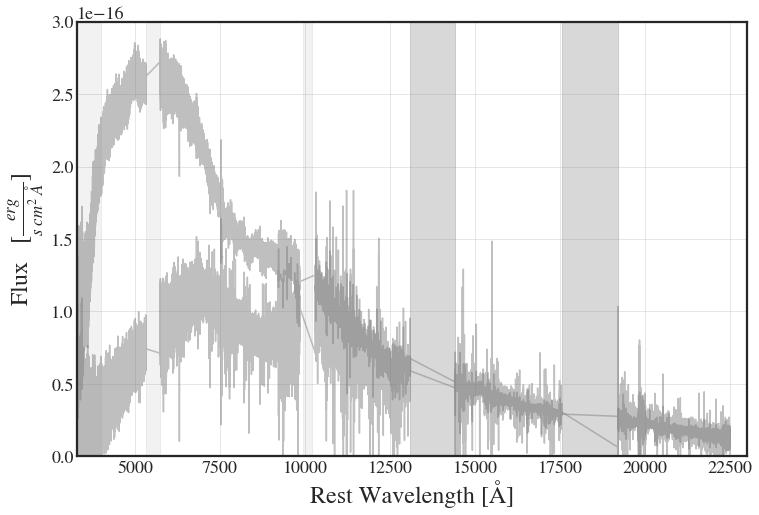

In [7]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)
plt.plot(wl2, flux2, label='X-shooter spectra', color='grey', alpha=0.5)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [42]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    intensity = temp(wav, T)
    
    # One Line Pcygni
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, tau   , lam, vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]
    
    lam = v['lam0']
    
    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, lam = lam)
    
    if data is None:
        return model
    return (model - data)/error

def residual2(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T2"], v["N2"], v["vphot2"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax2"], v["tau2"], v["vref"], v["ve2"], v["occult_2"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1_2"], v["amp2_2"], v["cen1"], v["cen2"], v["sig1_2"], v["sig2_2"]
    
    lam = v['lam0']
    
    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, lam = lam)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    delta = inter(vphot); corr = delta**4
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]

In [43]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    model2 = residual2(pars, wl2*1e-10)
    return lnprob_inner(model, flux, error) + lnprob_inner(model2, flux2, error2)


In [49]:
pickle_in = open("./data/OB1/OB1_1_line_40x10000.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('T2', value=3952, min=1000, max=5000)
p.add('N2', value=2.6774e-29)#, min=-np.inf, max=1)
p.add('vphot2', value= 0.25641418, min=0, max=1)
p.add('vmax2', value= 0.29007352 , min=0, max=1)
p.add('tau2', value=1.5520, min=0, max=10)
p.add('ve2', value=3.7515, min=0, max=10)
p.add('occult_2', value=1.98893372, min=0, max=10)
p.add('amp1_2', value= 0.7871, min=0, max=1)
p.add('amp2_2', value= 0.7874, min=0, max=1)
#p.add('cen1_2', value= 1.5168e-06 , min= 1.4000e-06 , max= 1.7000e-06 )
#p.add('cen2_2', value= 1.9006e-06 , min= 1.8000e-06 , max= 2.2000e-06 )
p.add('sig1_2', value= 7.2175e-08 , min= 1.0000e-08 , max= 3.0000e-07 )
p.add('sig2_2', value= 1.3176e-07 , min= 1.0000e-08 , max= 3.0000e-07 )

p['cen2'].min = 1.8e-6
#p['lam0'].value = 10456
#p['lam0'].vary = False
p

name,value,standard error,relative error,initial value,min,max,vary
T,5423.52997,1.49241522,(0.03%),5429.09784804552,2500.00000,7500.00000,True
N,1.3507e-29,1.7350e-32,(0.13%),1.3491976390739228e-29,-inf,inf,True
vphot,0.29477399,0.00148962,(0.51%),0.2859992843739608,0.00000000,1.00000000,True
vmax,0.37392308,0.00563878,(1.51%),0.34326170527513594,0.00000000,1.00000000,True
t0,126000.000,,(1.51%),126000,-inf,inf,False
tau,1.61888042,0.75663707,(46.74%),2.033110188934817,0.00000000,100.000000,True
vref,0.00000000,,(46.74%),0.0,0.00000000,1.00000000,False
ve,0.30139565,0.12893280,(42.78%),0.3196532921559495,0.00000000,1.00000000,True
occult,0.00115960,0.00330196,(284.75%),0.006491574677289003,0.00000000,2.00000000,True
amp1,0.27724395,0.00655648,(2.36%),0.27943752105569775,0.00000000,1.00000000,True


In [50]:
mini = lmfit.Minimizer(lnprob, p)

start = time.time()
nwalkers = 100 #v = p.valuesdict()
res2 = mini.emcee(nwalkers=nwalkers, burn=0, steps=4000, thin=1, params=p, seed=1, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

100%|██████████| 4000/4000 [2:14:09<00:00,  2.01s/it]  


The chain is shorter than 50 times the integrated autocorrelation time for 25 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 80;
tau: [358.8232389  367.88565897 220.68283278 218.93256034 580.84428726
 579.31948129 566.35415727 251.41826796 448.89004624 217.31391345
 184.58574955 437.31920434 245.24335929 201.47315543 470.71619916
 502.06134234 241.90364903 423.81497371 561.09855273 573.28352293
 575.85053261 292.36308646 441.14241395 338.77651748 393.62641579]
Time elapsed [hours]: 2.23702427274651


In [52]:
res2.params

name,value,standard error,relative error,initial value,min,max,vary
T,5430.29530,1.96587327,(0.04%),5423.5299663701035,2500.00000,7500.00000,True
N,1.3405e-29,2.4764e-32,(0.18%),1.3506717604237555e-29,-inf,inf,True
vphot,0.28699014,7.9136e-04,(0.28%),0.29477398701640795,0.00000000,1.00000000,True
vmax,0.35431486,0.00127645,(0.36%),0.3739230806186863,0.00000000,1.00000000,True
t0,126000.000,,(0.36%),126000,-inf,inf,False
tau,1.51748535,0.10746281,(7.08%),1.6188804224758078,0.00000000,100.000000,True
vref,0.00000000,,(7.08%),0.0,0.00000000,1.00000000,False
ve,0.32821883,0.02417614,(7.37%),0.30139565057797957,0.00000000,1.00000000,True
occult,0.00108781,9.0622e-05,(8.33%),0.001159597903015852,0.00000000,2.00000000,True
amp1,0.27368040,0.00529977,(1.94%),0.2772439502870212,0.00000000,1.00000000,True


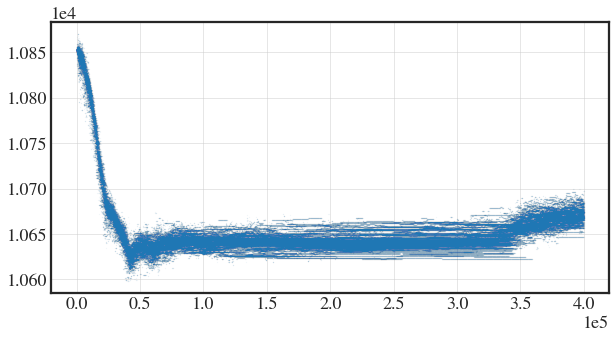

In [62]:
plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(res2.flatchain['lam0'])), res2.flatchain['lam0'], s=.05, alpha=.1)

In [63]:
#with open("./Data/OB1+OB2_1line_lam010643.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile)